## Firm Dynamics - Question 3
### Wei Han Chia

In this question, we solve the same problem of quadratic adjustment costs as in question 1. However, instead of iterating on the value function to solve for the firm's policy function, we will attempt to speed up the process by iterating on the first order condition.

In [118]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
import pickle

# to print plots inline
%matplotlib inline

### Parametrization
Let us begin with some preliminaries. Firstly, we will calibrate the model according to the following parameters. We also want to generate a grid for capital as well as a grid for the income shocks. We will build upon the model provided in the Deterministic Firm VFI notebook

We will use the following parametrization:


| Parameter | Description   | Value|
|------|------||------|
    | $\alpha_{k}$ | Capital's share of output | 0.297 |
   | $\alpha_{l}$ | Labor's share of output | 0.650 |
   | $\delta$ | Depreciation rate | 0.154 |
   | $\psi$ | Coefficient on quadratic adjustment costs | 1.080 |
   | $w$   | Wage rate | 0.700 |
   | $r$   | Interest rate | 0.040 |
   | $\sigma_z$   | Std dev of shocks | 0.213 |
   | $\mu$ | Mean of Income Process | 0 |
   | $\rho$ | Persistence of Income Process | 0.7605 |
   | `sizez` | Number of Grid Points of z | 9 |

In [3]:
# Parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
mu = 0
rho = 0.7605
sigma_z = 0.213
size_z = 9
betafirm = (1 / (1 + r))
params = alpha_k, alpha_l, delta, psi, w, r, betafirm

As with in Question 1, we generate our capital and shock grids.

In [102]:
def incomegrid(density, kstar):
    dens = density
    # Bouding state space based on steady state capital
    kbar = 2*kstar
    lb_k = 0.001
    ub_k = kbar
    krat = np.log(lb_k / ub_k)
    numb = np.ceil(krat / np.log(1 - delta))
    K = np.zeros(int(numb * dens))
    # we'll create in a way where we pin down the upper bound - since
    # the distance will be small near the lower bound, we'll miss that by little
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    kvec = K[::-1]
    return kvec

#Compute steady state capital
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))

kvec3 = incomegrid(2, kstar)

# Generating grid of transition probabilities and nodes
import ar1_approx as ar1
step = (4 * sigma_z) / (size_z/ 2)
pi, zvec3 = ar1.rouwen(rho, mu, step, size_z)

array([ 0.4689152 ,  0.56665762,  0.68477383,  0.82751062,  1.        ,
        1.2084437 ,  1.46033618,  1.76473405,  2.13258175])

### First Order Condition

Recall from our notes that we solved for the simplified FOC
$$ 1 + c_1(k',k) = \beta[\mathbb{E}_{z'|z} [\pi_2(z',k') + (1 - \delta) - c_2(k'',k')]] $$

We also have the following formulations for cost and profit functions:

$$c(k',k) = \frac{\psi}{2}\frac{(k' - (1 - \delta)k)^2}{k} $$

$$ \pi(z,k) = (1 - \alpha_l) (\frac{\alpha_l}{w})^{\frac{\alpha_l}{1 - \alpha_l}} z^{\frac{1}{1 - \alpha_l}} k^{\frac{\alpha_k}{1 - \alpha_l}} $$

Now we can take the related derivatives:

$$ c_1(k',k) = \frac{\psi(k' - (1 - \delta)k)}{k} $$
$$ c_2(k',k) = \frac{\psi}{2}\frac{2(k' - (1 - \delta)k)(\delta - 1)k - (k' - (1 - \delta)k)^2}{k^2} $$
$$ \pi_2(z,k) = \alpha_k (\frac{\alpha_l}{w})^{\frac{\alpha_l}{1 - \alpha_l}} z^{\frac{1}{1 - \alpha_l}} k^{\frac{\alpha_k + \alpha_l - 1}{1 - \alpha_l}} $$

Finally, we can simplify our FOC further using these functional forms to get an inverted value of $k$ given $k'$

$$ k = \frac{\psi k' }{\beta[\mathbb{E}_{z'|z}[ \pi_2(z',k') + (1 - \delta) - c_2(k'', k')]] + \psi(1 - \delta) -1} $$

Let us define each of our partial derivative functions for easy solutions later.

In [112]:
def pi2(k, z, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    return alpha_k * ((alpha_l / w)) ** (alpha_l / (1 - alpha_l)) * z ** (1 / (1 - alpha_l)) * \
           k ** ((alpha_k + alpha_l - 1)/(1 - alpha_l))
    
def c2(kprime, k, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    return (psi / 2) * (2*(kprime - (1 - delta)*k)*(delta - 1)*k - (kprime - (1 - delta)*k)**2)/(k**2)
# Define inverse function to get k

def kinv(kprime, expectedvalue, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    return ( psi * kprime )/( betafirm * expectedvalue + psi*(1 - delta) - 1)
    

Now note that given the formulation of our simplified FOC, we are actually in the position to use the Endogenous Grid Method to iterate on our policy function.

In [113]:
def solvefirmdynamics(kvec, zvec, pi, params, tol=1e-06, maxiter=3000):
    '''
    kvec = k by 1 Vector of Capital Grid 
    zvec = z by 1 Vector of Shock grid
    pi = Transition Probabilities
    params = Other exogenous parameters
    tol = tolerance of error
    maxiter = maximum number of iterations
    
    Purpose: Solving for policy functions for firms facing stochastic shocks and
    quadratic adjustment costs using EGP method
    
    Returns: k by z vector of optimal choice of kprime in the next period'''
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    size_k = kvec.shape[0]
    size_z = zvec.shape[0]
    PFtol = tol
    PFdist = 7.0
    PFmaxiter = maxiter
    kchoice = np.arange(0, size_k, 1)
    PF = np.reshape(np.repeat(kchoice, 9, axis=0), (size_k, size_z))  # k by z size matrix of indexes
    PF = kvec3[PF] # Initial guess of policy function
    kinvgrid = np.zeros(size_k) # Grid to store inverted K values
    kprimeprime = np.zeros(size_z) # Grid of second period choice of investment
    PFiter = 1
    start_time = time.clock()

    while PFdist > PFtol and PFiter < PFmaxiter:
        TPF = np.copy(PF)
        for j in range(size_z): # Loop over z
            for i in range(size_k): # Loop over k
                for k in range(size_z): # Loop over z'
                    kprimeprime[k] = np.interp(TPF[i,j], kvec, TPF[:,k])
                expectedvalue = (pi2(TPF[i,j], zvec, params) + (1 - delta) - c2(kprimeprime,TPF[i,j],params)).dot(pi[:,j])
                kinvgrid[i] = kinv(TPF[i,j], expectedvalue, params)
            PF[:,j] = np.interp(kvec, kinvgrid, TPF[:,j])
        PFdist = (np.absolute(PF - TPF)).max()
        PFiter += 1
    
    PF_time = time.clock() - start_time
    if PFiter < PFmaxiter:
        print('Policy function converged after this many iterations:', PFiter)
    else:
        print('Policy function did not converge')
    print('EGP took ', PF_time, ' seconds to solve')
        
    return PF  # solution to the functional equation
    

In [120]:
optKegp = solvefirmdynamics(kvec3, zvec3, pi, params)

Policy function converged after this many iterations: 45
EGP took  18.41110676669723  seconds to solve


In [121]:
# Backing out Investment Policy
optIegp = np.empty((kvec3.shape[0], zvec3.shape[0]))
for i in range(9):
    optIegp[:,i] = optKegp[:,i] - (1 - delta) * kvec3

We see that the endogenous grid points method both uses significantly less iterations, and is much faster than the value function iteration method used in question 1.

### Results

We can compare the policy functions returned by our EGP method and the VFI method.

In [134]:
# Loading in Results from Q1
q1_results = pickle.load(open("q1results.p", "rb" ))
optI = q1_results['Ipolicy']
optK = q1_results['Kpolicy']

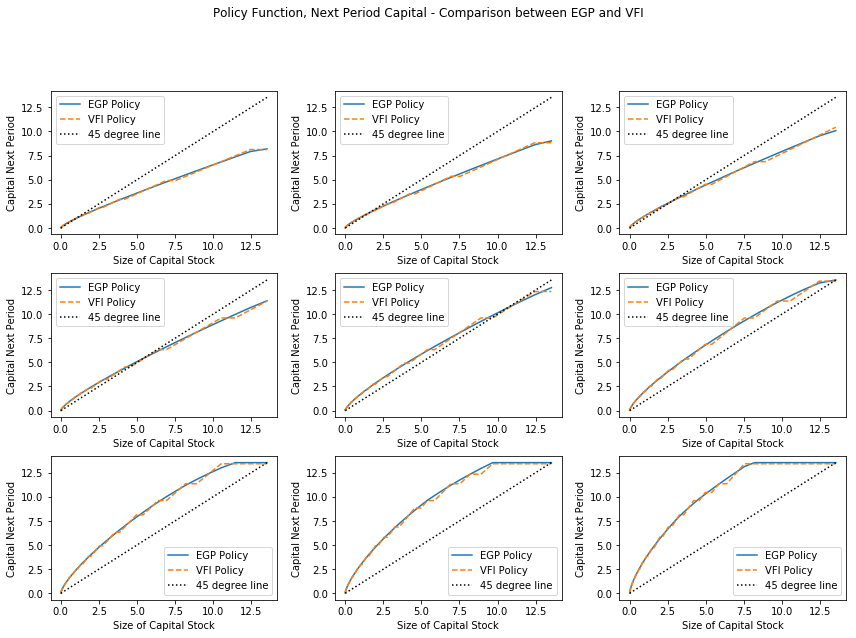

In [142]:
plt.rcParams["figure.figsize"] = [12,9]
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(kvec3, optKegp[:,i], label='EGP Policy', linestyle="-")
    plt.plot(kvec3, optK[:,i], label='VFI Policy', linestyle="--")
    plt.plot(kvec3, kvec3, 'k:', label='45 degree line')
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Capital Next Period')
    plt.legend()

plt.suptitle('Policy Function, Next Period Capital - Comparison between EGP and VFI')
plt.tight_layout()
plt.subplots_adjust(top = 0.85)
plt.show()

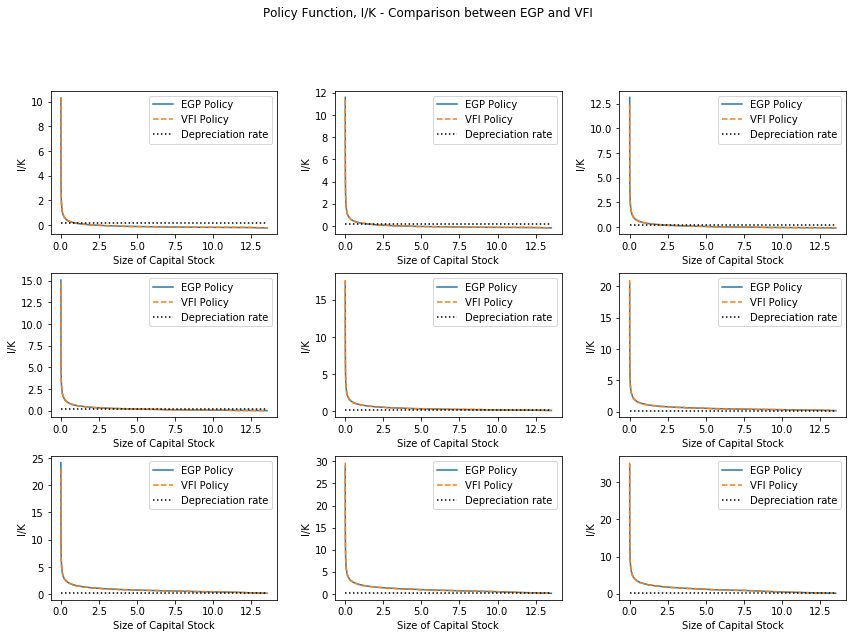

In [143]:
plt.rcParams["figure.figsize"] = [12,9]
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(kvec3, optIegp[:,i]/kvec3, label='EGP Policy', linestyle="-")
    plt.plot(kvec3, optI[:,i]/kvec3, label='VFI Policy', linestyle="--")
    plt.plot(kvec3,(np.ones(kvec3.shape[0])*delta), 'k:', label='Depreciation rate')
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('I/K')
    plt.legend()

plt.suptitle('Policy Function, I/K - Comparison between EGP and VFI')
plt.tight_layout()
plt.subplots_adjust(top = 0.85)
plt.show()

As we expected, our policy functions match well, with the additional fact that unlike the jumpier VFI policy function, the policy functions from our endogenous grid is smooth because of the interpolation done at each step. In this case, the additional speed provided by the EGP method makes it preferred.